Laboratorium miało na celu zapoznanie się z pogłosem, jego wpływem na sygnał oraz porównaniem jak bardzo zmienia się sygnał źródłowy.

Importy:

In [1]:
from __future__ import annotations
from scipy.io import wavfile
from scipy.signal import convolve
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
import warnings

warnings.simplefilter("ignore")

Funkcja monofonizująca (uśredniająca) podany sygnał, jeżeli ma 2 kanały:

In [2]:
def monophonize(data: np.array) -> np.array:
    if len(data.shape) == 1:
        return data

    return data.sum(axis=1) / 2

Klasa pomocnicza reprezentująca sygnał. Domyślnie monofonizuje dostarczone dane i zapisuje konwertuje do typu float.
Klasa ta została wykorzystana na pierwszych laboratoriach.

In [3]:
class Signal:
    def __init__(self, fs: int, data: np.array):
        self.data: np.array = monophonize(data).astype(np.float32)
        self.fs: int = fs

    def change_samplerate(self, new_fs: int) -> Signal:
        return Signal(
            new_fs,
            self.__down_sample_signal(new_fs) if new_fs < self.fs else self.__up_sample_signal(new_fs),
        )

    def save_to_file(self, filepath: str) -> None:
        wavfile.write(filepath, self.fs, self.data.astype(np.int32))

    @property
    def shape(self) -> tuple:
        return self.data.shape

    @property
    def length(self) -> float:
        return self.shape[0] / self.fs

    def __down_sample_signal(self, samplerate: int) -> np.array:
        ratio = samplerate / self.fs

        return self.data[np.unique(np.around(np.arange(self.shape[0]) * ratio).astype(int))]

    def __up_sample_signal(self, samplerate: int) -> np.array:
        ratio = samplerate / self.fs
        new_samples = np.full((np.round(self.shape[0] * ratio).astype(int), self.shape[1]), np.nan)

        for dim in range(self.shape[1]):
            new_samples[np.around(np.arange(self.shape[0]) * ratio).astype(int), dim] = self.data[:, dim]

            start_nan_index = -1

            for sample_iter, sample in enumerate(new_samples[:, dim]):
                if np.isnan(sample) and start_nan_index == -1:
                    start_nan_index = sample_iter
                    continue

                if not np.isnan(sample) and start_nan_index != -1:
                    mean_between_samples = np.mean([new_samples[start_nan_index - 1, dim], new_samples[sample_iter, dim]])
                    new_samples[start_nan_index - 1:sample_iter + 1] = mean_between_samples
                    start_nan_index = -1
                    continue

        return new_samples


Pomocnicza klasa wizualizująca dane. Zawiera same metody statyczne.

In [4]:
class Visualizer:
    @staticmethod
    def visualize_iir(data) -> None:
        plt.figure(figsize=(20, 10))
        plt.plot(data)
        plt.title('Impulse response')
        plt.xlabel('Coefficient number')
        plt.ylabel('Coefficient value')
        plt.show()
        plt.close()

    @staticmethod
    def compare_normal_with_convolved(normal: Signal, convolved: Signal, name: str) -> None:
        plt.figure(figsize=(20, 10))

        plt.subplot(211)
        plt.title(f'{name.capitalize()} signal')
        plt.xlabel('Time [s]')
        plt.ylabel('Amplitude')
        plt.plot(np.linspace(0, normal.length, normal.shape[0]), normal.data)

        plt.subplot(212)
        plt.title(f'Convolved {name.lower()} signal')
        plt.xlabel('Time [s]')
        plt.ylabel('Amplitude')
        plt.plot(np.linspace(0, convolved.length, convolved.shape[0]), convolved.data)

        plt.show()
        plt.close()

    @staticmethod
    def compare_normal_with_convolved_by_spectrogram(normal: Signal, convolved: Signal, name: str) -> None:
        plt.figure(figsize=(20, 10))

        plt.subplot(211)
        plt.title(f'Spectrogram of {name.lower()} signal')
        plt.xlabel('Time [s]')
        plt.ylabel('Frequency [Hz]')
        wiki_spectrum, _, _, _ = plt.specgram(normal.data, Fs=normal.fs)
        plt.colorbar()

        plt.subplot(212)
        plt.title(f'Spectrogram of convolved {name.lower()} signal')
        plt.xlabel('Time [s]')
        plt.ylabel('Frequency [Hz]')
        wiki_convolved_spectrum, _, _, _ = plt.specgram(convolved.data, Fs=convolved.fs)
        plt.colorbar()

        plt.show()
        plt.close()

        mse = mean_squared_error(wiki_spectrum, wiki_convolved_spectrum)
        print(f'mse for {name}: {mse}')

Wczytanie pogłosu i wizualizacja jego współczynników:

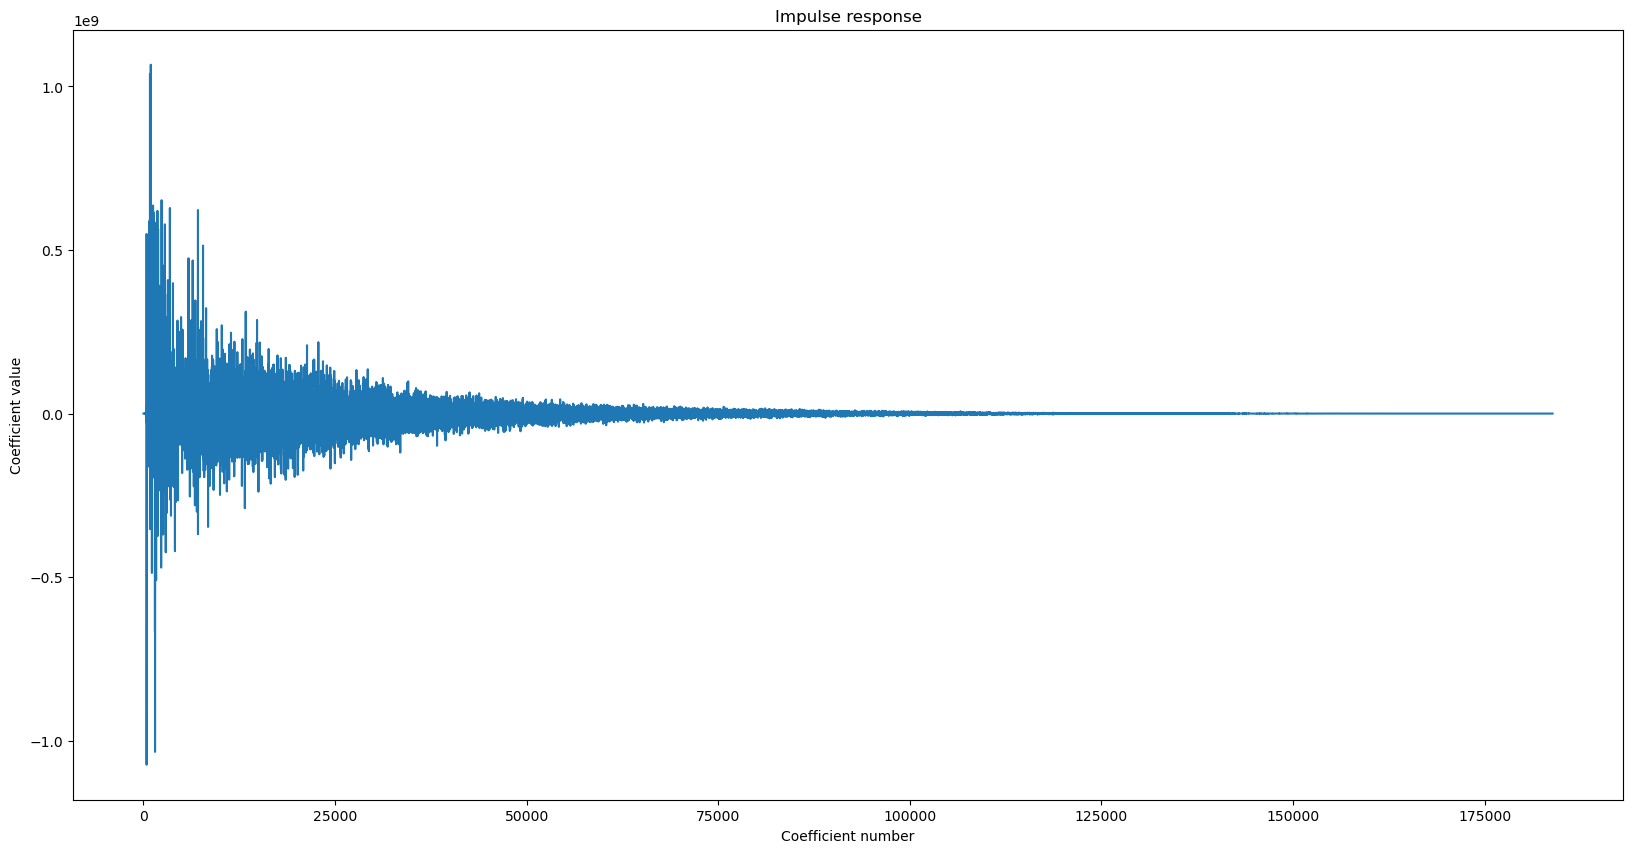

In [5]:
iir = Signal(*wavfile.read('./iir/01_CzM--Auto_Park.wav'))
Visualizer.visualize_iir(iir.data)

Wczytanie sygnału 'wiki', nałożenie na niego pogłosu oraz zapisanie do pliku sygnału z nałożonym pogłosem:

In [6]:
wiki = Signal(*wavfile.read('./signals/wiki_bioinformatics.wav'))
wiki_convolved = Signal(wiki.fs, convolve(wiki.data, iir.data, mode='same'))
wiki_convolved.save_to_file('./signals/wiki_convolved.wav')

Wizualizacje porównujące sygnał źródłowy do sygnału z nałożonym pogłosem:

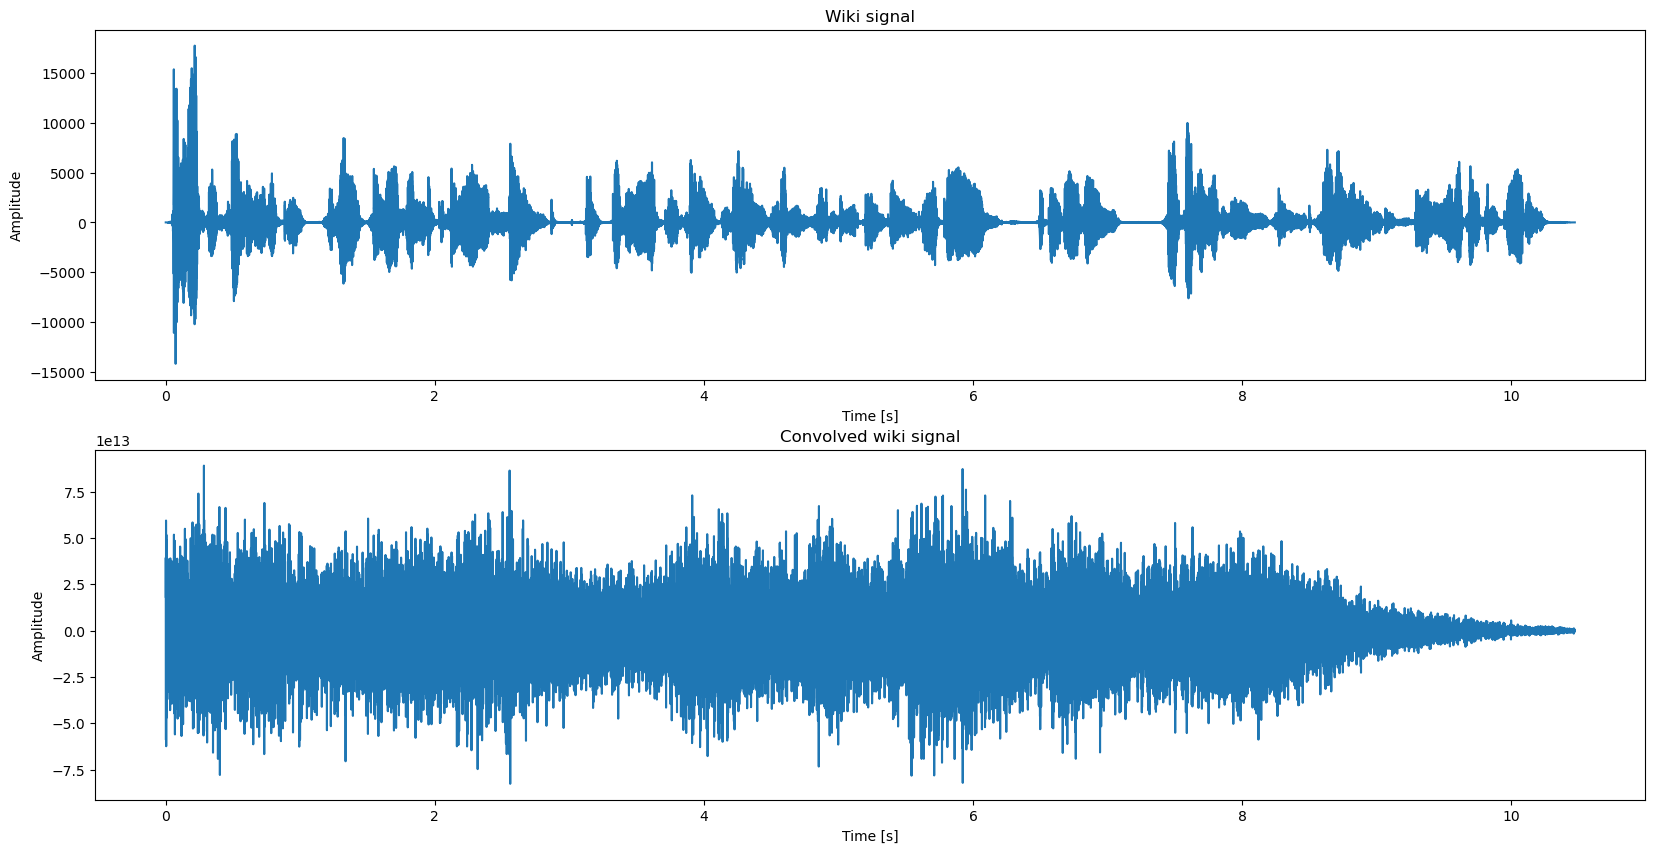

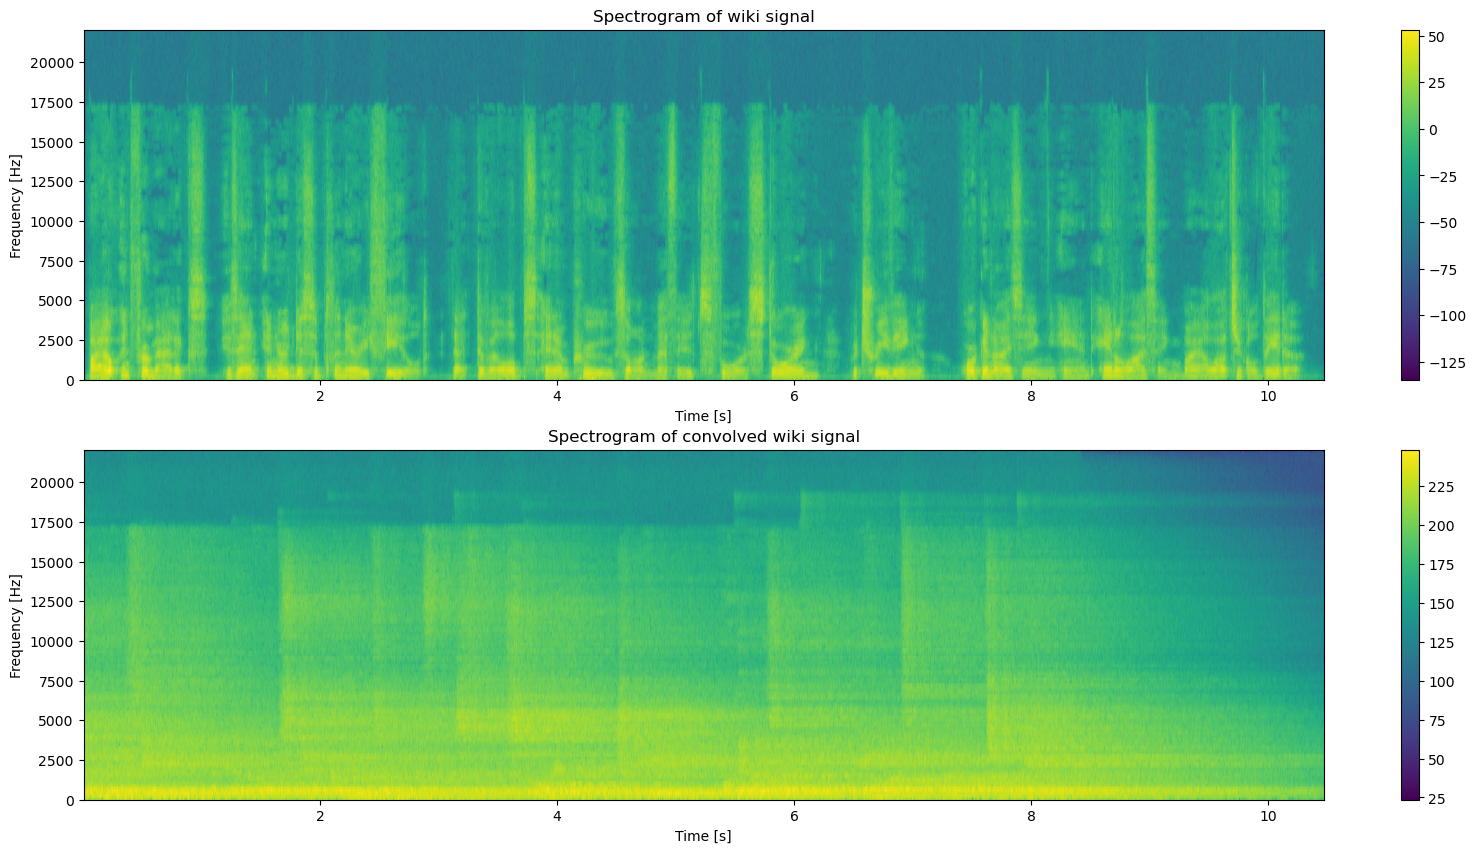

mse for wiki: 1.2911994263066525e+46


In [7]:
Visualizer.compare_normal_with_convolved(wiki, wiki_convolved, 'wiki')
Visualizer.compare_normal_with_convolved_by_spectrogram(wiki, wiki_convolved, 'wiki')

Wczytanie sygnału 'york' oraz dokonanie zmiany resamplingu, ze względu na różnice pomiędzy sygnałem a pogłosem w częstotliwościach próbkowania. 
Nałożenie pogłosu na sygnał oraz zapisanie sygnału z pogłosem do pliku.

In [8]:
york = Signal(*wavfile.read('./signals/york_drums.wav'))
york = york.change_samplerate(iir.fs)
york_convolved = Signal(wiki.fs, convolve(york.data, iir.data, mode='same'))
york_convolved.save_to_file('./signals/york_convolved.wav')

Wizualizacje porównujące sygnał źródłowy do sygnału z nałożonym pogłosem:

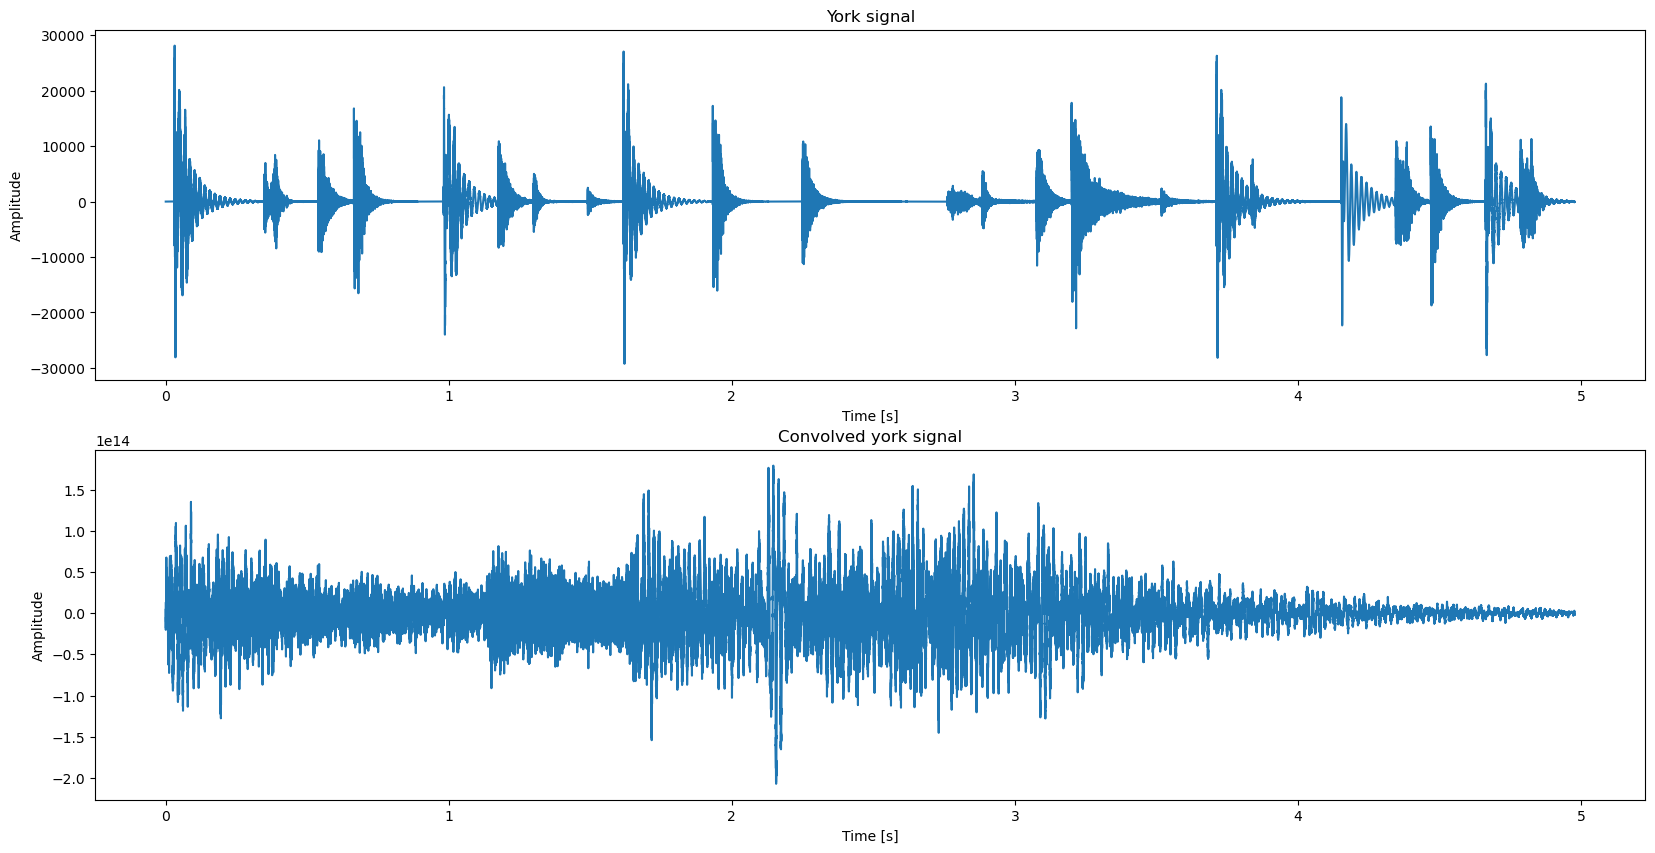

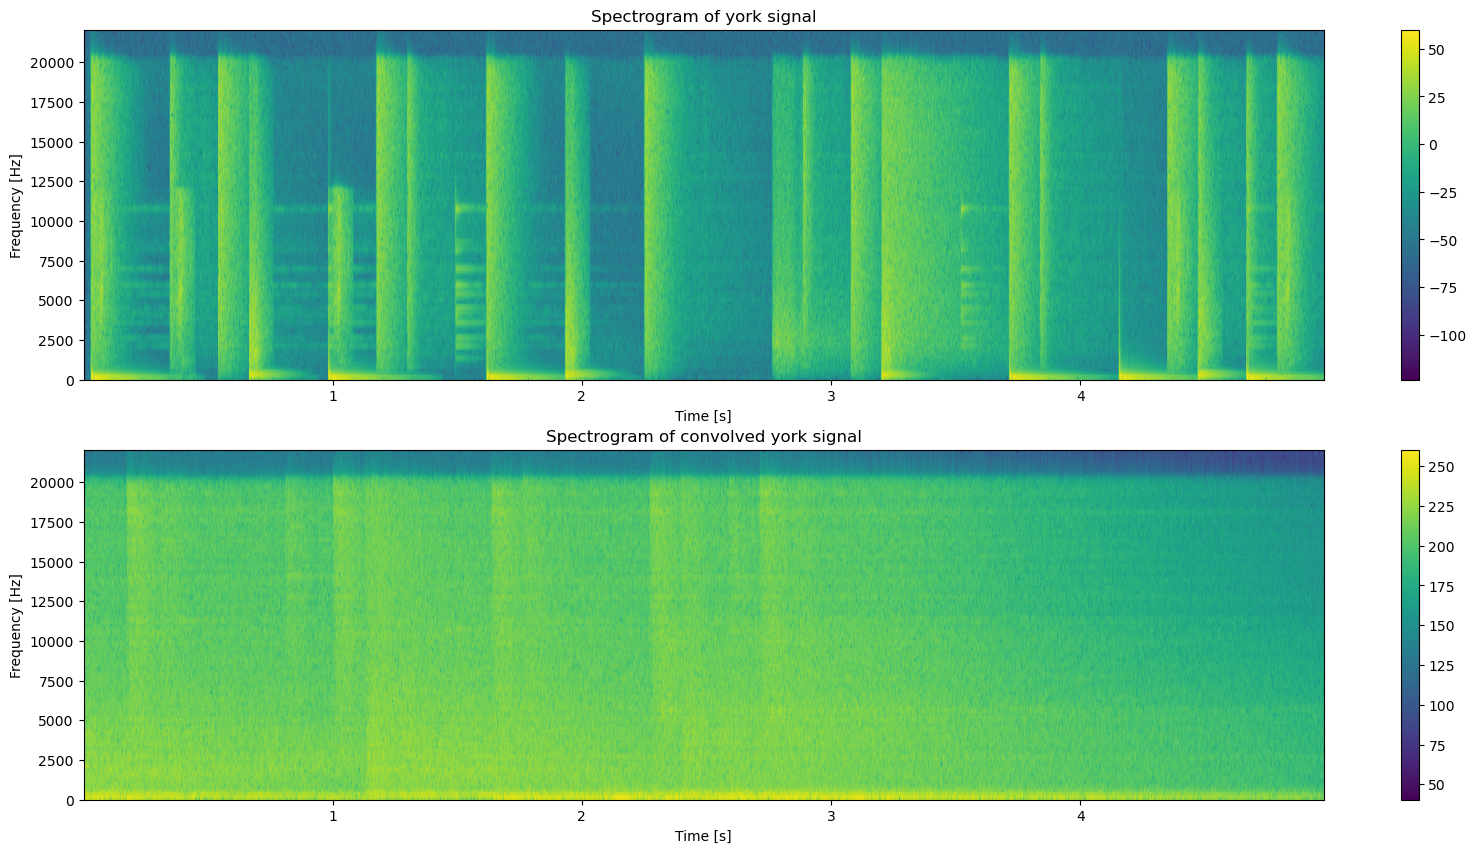

mse for york: 4.938784359188453e+47


In [9]:
Visualizer.compare_normal_with_convolved(york, york_convolved, 'york')
Visualizer.compare_normal_with_convolved_by_spectrogram(york, york_convolved, 'york')

Wnioski:
* Zastosowany został pogłos numer 01.
* Pogłos jest dość mocny i długi, trwający ponad 3 sekundy. Sprawia to, że wynikowe spektrogramy sygnałów z nałożonym pogłosem są bardzo rozmazane. 
* Różnica jest także słyszalna przy odsłuchiwaniu dźwięków z nałożonym pogłosem. Słyszalne są trzeszczenia, jednak są one słabe - pogłos ten mocno zaburza, zasłania sygnał źródłowy.
* Im mocniejszy pogłos, tym mniej jest częstotliwości słyszalnych dla ludzkiego ucha, co oznacza w większości słyszalna jest cisza - porównywane w odsłuchu z innymi krótszymi i lżejszymi pogłosami.
* Błędy średniokwadratowe są bardzo duże, co świadczy o mocnym zaburzeniu sygnału źródłowego przez pogłos.
* Dość mocno także zmienia się oś Y na wykresach - sygnał z nałożonym pogłosem ma wartości znacznie większe na tej osi w porównaniu do sygnału bez pogłosu.